In [1]:
#importing necessary packages
import math
import numpy as np
import scipy
import matplotlib

In [2]:
#Loading the mel filterbanks
mel_filters = np.load('/content/mel_filters.npy')

#Loading the reference mfcc
ref_mfccs = np.load('/content/reference_mfcc.npy')

In [3]:
#Step 1: load the audio file
import scipy.io.wavfile as wavfile

sample_rate, audio_data = wavfile.read('/content/signal.wav')
print("Sampling rate:", sample_rate)

num_samples = len(audio_data)
print("Number of samples:", num_samples)

duration_seconds = num_samples / sample_rate
print("Duration in seconds:", duration_seconds)

Sampling rate: 16000
Number of samples: 18091
Duration in seconds: 1.1306875



*   Sampling rate: 16000
*   Number of samples: 18091
*   Duration in seconds: 1.1306875


In [4]:
#Step 2: DC subtraction (i.e. remove the mean of the signal)

# Calculate the average value x0 of x1[n]
x0 = audio_data.mean()

# Perform mean subtraction to obtain x2[n]
x2 = audio_data - x0


In [5]:
#Step 3: pre-emphasis filtering

# Define the pre-emphasis coefficient
b = 0.97

# Create an empty array to store the pre-emphasized samples x3[n]
x3 = np.zeros_like(x2)

# Compute x3[n] for n = 0 (special case)
x3[0] = x2[0]

# Compute x3[n] for n > 0
for n in range(1, len(x2)):
    x3[n] = x2[n] - b * x2[n - 1]


In [6]:
#Step 4: Transforming the audio into a sequence of frames

import numpy as np

def frame_signal(x, L, S):
    """
    Frame a signal into overlapping windows.

    Args:
    - x: The input signal (1-D NumPy array).
    - L: Window length (number of samples per frame).
    - S: Window shift (number of samples to advance between frames).

    Returns:
    - framed_signal: A 2-D NumPy array where each row represents a frame.
    """

    N = len(x)  # Length of the input signal

    remainder = (N-L) % S
    if remainder !=0:
      pad = S-remainder
      pad_array = np.zeros(pad)
      padded_x = np.append(x, pad_array)
      N = len(padded_x)


    Nf = (N - L) // S +1 # Number of frames

    # Initialize a matrix to store the framed representation
    framed_signal = np.zeros((Nf, L))

    # Create frames by extracting windows with the specified shift
    for k in range(Nf):
        start = k * S
        end = start + L
        framed_signal[k][:] = padded_x[start:end]
    return framed_signal


In [7]:
#Step 5: Applying the window function

import numpy as np
from scipy.signal.windows import hamming
#scipy.signal.windows.hamming

def apply_hamming_window(frame):
    """
    Apply a Hamming window to a single frame.

    Args:
    - frame: 1-D NumPy array representing a single frame.

    Returns:
    - frame_windowed: The frame after applying the Hamming window.
    """

    # Apply the Hamming window element-wise
    frame_windowed = frame * hamming(len(frame))

    return frame_windowed

In [8]:
# computing Logmel and power spectrum
def compute_logmel_powspec(framed_signal):
  N = 512
  logmel = []
  powspec = []
  for frame in framed_signal:

    #Step 5(a): Applying the window function
    frame_windowed = apply_hamming_window(frame)

    #Step 5(b): Computing the Fourier transform

    # Compute the DFT of the frame
    dft_result = fft(frame_windowed, n=N)

    #Step 5(c) and 5(d): Computing the magnitude and power spectra

    # Magnitude
    x_mag = np.abs(dft_result)
    #print(x_mag.shape)

    # Power spectrum
    x_pow = np.square(x_mag)

    #Step 5(e): Mel-filterbank application
    x_pow_slice = x_pow[:257]
    x_mel = np.dot(mel_filters, x_pow_slice)

    #Step 5(f): Taking the log

    log_x_mel = np.log(x_mel)
    x_logmel = np.maximum(-50, log_x_mel)
    logmel.append(x_logmel)

    x_powspec = np.maximum(-50, np.log(x_pow_slice))
    powspec.append(x_powspec)

  logmel = np.array(logmel)
  powspec = np.array(powspec)
  return logmel, powspec

In [9]:
from scipy.fft import fft
from scipy.fftpack import dct


def pipeline(frame):

  N = 512

  #Step 5(a): Applying the window function
  frame_windowed = apply_hamming_window(frame)

  #Step 5(b): Computing the Fourier transform

  # Compute the DFT of the frame
  dft_result = fft(frame_windowed, n=N)

  #Step 5(c) and 5(d): Computing the magnitude and power spectra

  # Magnitude
  x_mag = np.abs(dft_result)
  #print(x_mag.shape)

  # Power spectrum
  x_pow = np.square(x_mag)

  #Step 5(e): Mel-filterbank application
  x_pow_slice = x_pow[:257]
  #print(x_pow_slice.shape)
  x_mel = np.dot(mel_filters, x_pow_slice)

  #Step 5(f): Taking the log

  log_x_mel = np.log(x_mel)
  x_logmel = np.maximum(-50, log_x_mel)
  #x_logmel = np.maximum(-50, log_x_mel)

  #Step 5(g): Computing the DCT
  #Step 5(h): Truncating the DCT
  mfcc_frame = np.zeros(13)
  for cep in range(13):
      for mel_bin in range(len(mel_filters)):
          angle = np.pi * cep * (2 * mel_bin + 1) / (2 * len(mel_filters))
          mfcc_frame[cep] += x_logmel[mel_bin] * np.cos(angle)

  return mfcc_frame


In [10]:
window_length = 25
window_shift = 10
L = int((25 / 1000) * sample_rate)
S = int((10 / 1000) * sample_rate)

In [11]:
framed_signal = frame_signal(x3, L, S)
final_mfccs = np.apply_along_axis(pipeline, axis=1, arr=framed_signal)
logmel, powspec = compute_logmel_powspec(framed_signal=framed_signal)

In [12]:
import numpy as np

# 'mfccs' and 'reference_mfccs' are both 2D NumPy arrays with shape (112, 13)

# Calculate the squared differences element-wise
squared_diff = np.square(final_mfccs - ref_mfccs)

# Calculate the Mean Squared Error for each list of values
mse = np.mean(squared_diff)


print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 8.393636069972379e-27


Mean Squared Error (MSE): 8.393636069972379e-27

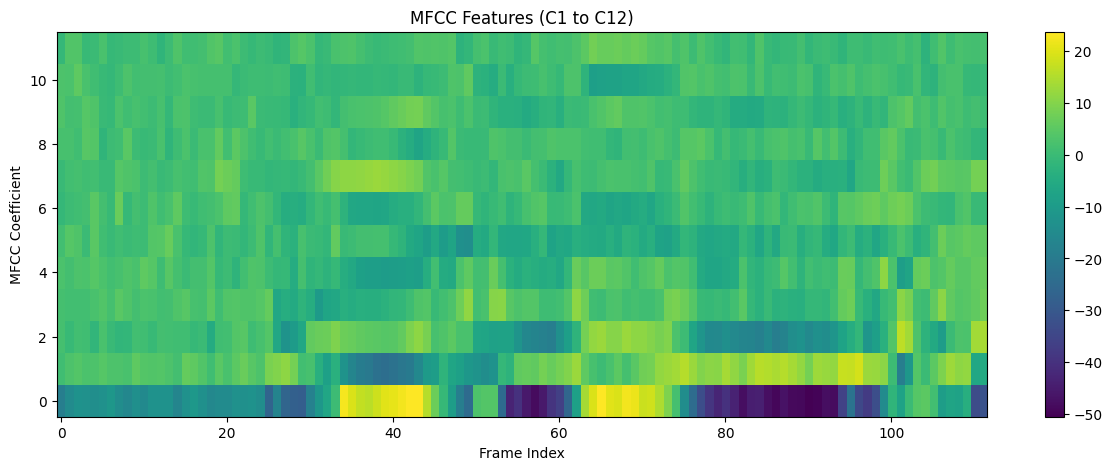

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'mfccs' is a 2D NumPy array with shape (112, 13)
# num_coefficients should be at least 13 for C0 through C12

# Extract only C1 through C12 (excluding C0)
mfccs_subset = final_mfccs[:, 1:13]
plt.figure(figsize=(15,5))
# Create a heatmap using imshow
plt.imshow(mfccs_subset.T, cmap='viridis', origin='lower', aspect='auto')

# Add labels and title
plt.xlabel('Frame Index')
plt.ylabel('MFCC Coefficient')
plt.title('MFCC Features (C1 to C12)')

# Show the colorbar
plt.colorbar()

# Display the plot
plt.show()


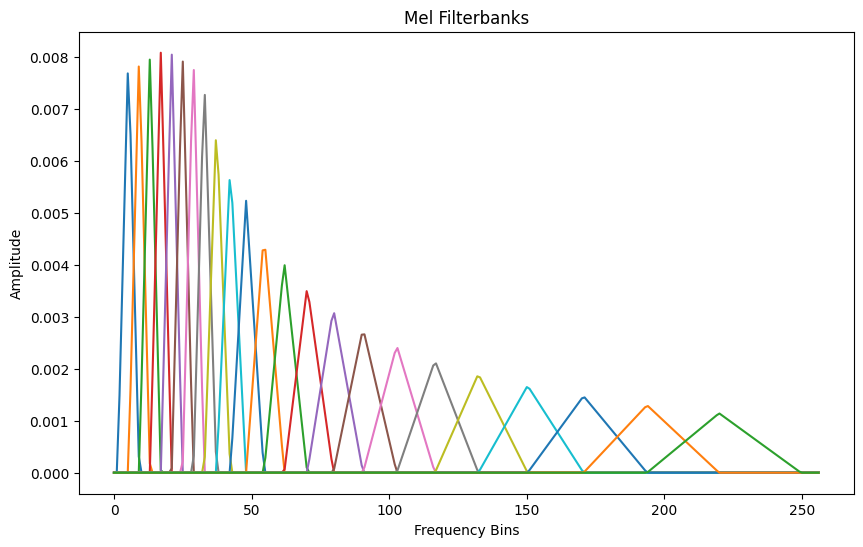

In [14]:
#Step 8: Mel-filterbank application

import numpy as np
import matplotlib.pyplot as plt

# Plot the filterbanks
plt.figure(figsize=(10, 6))
plt.plot(mel_filters.T)
plt.title("Mel Filterbanks")
plt.xlabel("Frequency Bins")
plt.ylabel("Amplitude")
plt.show()


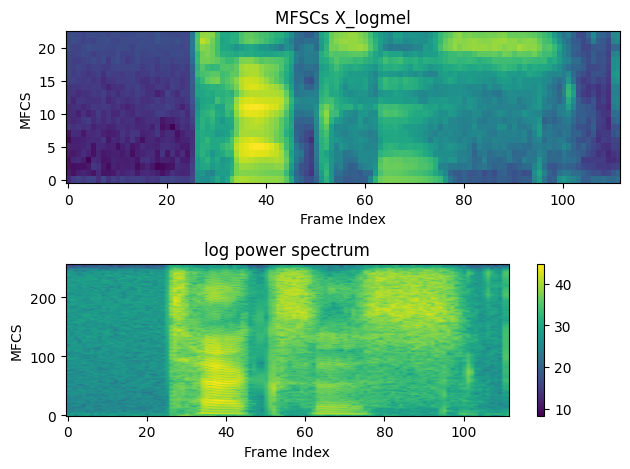

In [15]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.xlabel('Frame Index')
plt.ylabel('MFCS')
plt.title('MFSCs X_logmel')
# Create a heatmap using imshow
plt.imshow(logmel.T, cmap='viridis', origin='lower', aspect='auto')


plt.subplot(2,1,2)
plt.xlabel('Frame Index')
plt.ylabel('MFCS')
plt.title('log power spectrum')
#plt.figure(figsize=(15,5))

# Create a heatmap using imshow
plt.imshow(powspec.T, cmap='viridis', origin='lower', aspect='auto')


# Show the colorbar
plt.colorbar()
plt.tight_layout()
# Display the plot
plt.show()


When we look at the pictures, we can see that the MFSCs and the log power spectrum are quite different. The MFSCs have more detailed and complex patterns with clear high and low points. In contrast, the log power spectrum looks smoother and doesn't have as many distinct features. This difference happens because the MFSCs use specific information about different frequencies from the Mel filterbank. This helps them find small details and structures in the speech signal that you can't easily see in the log power spectrum.

On the other hand, the log power spectrum gives a more general view of the signal, even though it's not as detailed. It can still show important things about the signal, like its overall shape and how strong it is at different frequencies.

In [16]:
window_length = 4
window_shift = 1
L = int((4 / 1000) * sample_rate)
S = int((1 / 1000) * sample_rate)


In [17]:
framed_signal2 = frame_signal(x3, L, S)
final_mfccs_2 = np.apply_along_axis(pipeline, axis=1, arr=framed_signal2)
logmel2, powspec2 = compute_logmel_powspec(framed_signal=framed_signal2)

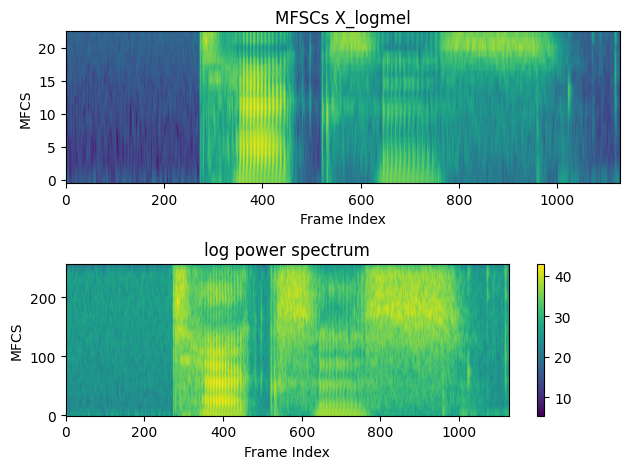

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Extract only C1 through C12 (excluding C0)
plt.subplot(2,1,1)
plt.xlabel('Frame Index')
plt.ylabel('MFCS')
plt.title('MFSCs X_logmel')
#plt.figure(figsize=(15,5))
# Create a heatmap using imshow
plt.imshow(logmel2.T, cmap='viridis', origin='lower', aspect='auto')


plt.subplot(2,1,2)
plt.xlabel('Frame Index')
plt.ylabel('MFCS')
plt.title('log power spectrum')
#plt.figure(figsize=(15,5))
# Create a heatmap using imshow
plt.imshow(powspec2.T, cmap='viridis', origin='lower', aspect='auto')

# Show the colorbar
plt.colorbar()
plt.tight_layout()
# Display the plot
plt.show()


Long Window Length:

MFSC Plot: With a long window length, the MFSC plot exhibits a smoother and more generalized representation of the speech signal. It is less sensitive to rapid changes in the signal and provides a broader view of the overall spectral characteristics. This is because the longer window averages out short-term fluctuations, resulting in a coarser representation.

Log Mel Spectrum Plot: Similarly, the log Mel spectrum plot with a long window length also appears smoother and less detailed. It captures the broader spectral features of the signal but misses finer structural details and rapid variations. This is because longer windows tend to average out high-frequency components and provide a more integrated view.

Short Window Length:

MFSC Plot: When using a short window length, the MFSC plot shows a more detailed and intricate pattern. It is highly sensitive to rapid changes in the signal, making it suitable for capturing transient events and subtle nuances. The short window allows for precise time resolution, resulting in distinct peaks and valleys.

Log Mel Spectrum Plot: The log Mel spectrum plot with a short window length also exhibits more pronounced variations and finer structural details. It is sensitive to rapid changes in the signal's spectral content, showing sharper peaks and valleys. However, it also introduces more noise and spectral leakage due to its high sensitivity.

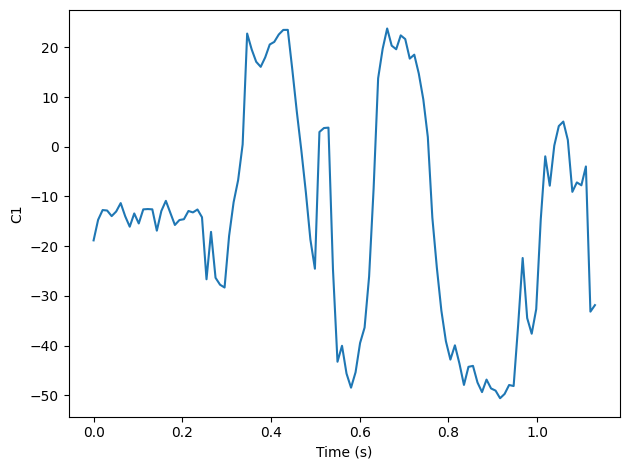

In [19]:
c_1 = final_mfccs[:,1]
time = np.linspace(0, (len(audio_data)/sample_rate), len(c_1))
plt.plot(time, c_1)
plt.xlabel('Time (s)')
plt.ylabel('C1')
plt.tight_layout()
plt.show()

When we look at C1 values during vowels and fricatives, we notice some differences.

Vowels:

During vowels, the C1 value is higher. This happens because vowels have a steady and noticeable pitch.
Specifically, when we check the C1 coefficient for i = 1 (the first cosine term), it has a higher positive value during vowels. This means that the first cosine term, which looks at slow changes in the sound, is important during vowels.

Fricatives:

For fricatives, it's a bit different. The C1 value during fricative is lower, and they vary more. This is because fricatives don't have a clear and steady pitch like vowels.
When we look at the C1 coefficient for i = 1 during fricatives, it tends to have a lower absolute value or might even be close to zero. This suggests that the first cosine term in the equation doesn't have as much impact on the overall C1 value during fricatives.
These differences in C1 values and the influence of the first cosine term tell us something important about how vowels and fricatives sound. Vowels have a stable pitch and show up as higher and more consistent C1 values. In contrast, fricatives have less defined pitch, resulting in lower and more variable C1 values.